In [2]:
%matplotlib inline
import sys,os
import matplotlib.pyplot as plt
import torch
import spartan2.spartan as st

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] ="0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
st.config(st.engine.SINGLEMACHINE)

In [4]:
# load time data
data = st.loadTensor(name = "example_time", path = "inputData/", col_types = [float, float, float], hasvalue=True)

Info: Tensor is loaded
           ----------------------
             attr     |	2
             values   |	True
             nonzeros |	36000



In [5]:
time_series = data.toTimeseries(attrlabels=['ecg_low', 'ecg_high'])

In [6]:
time_series.attrlists.shape
seg=st.series_segmentation.create(time_series,st.sseg_policy.RPeaks,"slide")

ts_segs=seg.run(360,120,136,None)
ts_segs=ts_segs[:,:1,:]
print(ts_segs.shape)

(122, 1, 256)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


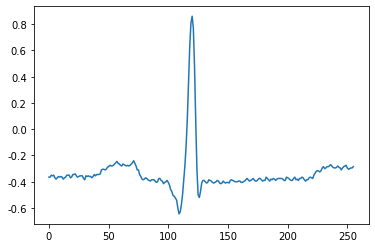

In [7]:
plt.plot(ts_segs[2][0,:])

In [8]:
# create a beatgan model

ad_model = st.anomaly_detection.create(time_series, st.ad_policy.BEATGAN, "my_beatgan_model")

In [9]:
### param for train model
param = {
    'network':'CNN',
    'net_type':'gru',
    'layers':1,
    'seq_len': 256,
    'input_size':1,
    'hidden_size':100,
    'rep_size':20,
    'batch_size':64,
    'max_epoch':5,
    'lr': 0.01,
    'lambda':1
}

In [10]:
ad_model.init_model(param,device)

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

In [11]:
ad_model.train(ts_segs)

 20%|██        | 1/5 [00:03<00:13,  3.34s/it]

0:loss_g(rec/adv):0.2785113751888275/1.0307481288909912,loss_d(real/fake):0.6122685670852661/0.9160639643669128


 40%|████      | 2/5 [00:06<00:09,  3.28s/it]

0:loss_g(rec/adv):0.23591360449790955/1.0075442790985107,loss_d(real/fake):1.862645149230957e-09/0.00010908902913797647


 60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

0:loss_g(rec/adv):0.18736624717712402/0.8118534088134766,loss_d(real/fake):0.0/0.0034312850330024958


 80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

0:loss_g(rec/adv):0.14187903702259064/0.8640466332435608,loss_d(real/fake):1.3038519597330378e-08/0.32825160026550293


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

0:loss_g(rec/adv):0.16012166440486908/0.7088649868965149,loss_d(real/fake):0.7292669415473938/1.105828046798706


In [12]:
ad_model.test(ts_segs)

[0.6631072  0.5572755  0.5765785  0.5528049  0.55869853 0.590561   0.5593564  0.61135983 0.5648409  0.5591167  0.5605883  0.55270463 0.582368   0.5864706
 0.5509123  0.54402995 0.5634396  0.55889064 0.7098478  0.5556601  0.62318474 0.60085946 0.55055076 0.589103   0.7404816  0.5605246  0.5649108  0.6296755
 0.5541568  0.5522931  0.5536763  0.69153523 0.5506469  0.54336727 0.5538394  0.6070891  0.5619104  0.5445274  0.5538625  0.6678756  0.54921585 0.5810564
 0.55650616 0.62748164 0.5457482  0.54810095 0.5776036  0.57986915 0.5581192  0.5489772  0.5516149  0.56432337 0.54983115 0.54551566 0.68999696 0.6961707
 0.5420884  0.5499122  0.58138597 0.7388661  0.550606   0.5724305  0.54932106 0.568741   0.5397873  0.62911725 0.71588296 0.5729088  0.56724066 0.6619705
 0.64645153 0.6133294  0.66643095 0.7040702  0.6480481  0.56586325 0.570891   0.59910834 0.5760287  0.60950196 0.59984004 0.68530214 0.5764785  0.5497888
 0.7253777  0.55488    0.55252093 0.6769183  0.63265914 0.5546087  0.5500545

array([0.6631072 , 0.5572755 , 0.5765785 , 0.5528049 , 0.55869853, 0.590561  , 0.5593564 , 0.61135983, 0.5648409 , 0.5591167 , 0.5605883 , 0.55270463,
       0.582368  , 0.5864706 , 0.5509123 , 0.54402995, 0.5634396 , 0.55889064, 0.7098478 , 0.5556601 , 0.62318474, 0.60085946, 0.55055076, 0.589103  ,
       0.7404816 , 0.5605246 , 0.5649108 , 0.6296755 , 0.5541568 , 0.5522931 , 0.5536763 , 0.69153523, 0.5506469 , 0.54336727, 0.5538394 , 0.6070891 ,
       0.5619104 , 0.5445274 , 0.5538625 , 0.6678756 , 0.54921585, 0.5810564 , 0.55650616, 0.62748164, 0.5457482 , 0.54810095, 0.5776036 , 0.57986915,
       0.5581192 , 0.5489772 , 0.5516149 , 0.56432337, 0.54983115, 0.54551566, 0.68999696, 0.6961707 , 0.5420884 , 0.5499122 , 0.58138597, 0.7388661 ,
       0.550606  , 0.5724305 , 0.54932106, 0.568741  , 0.5397873 , 0.62911725, 0.71588296, 0.5729088 , 0.56724066, 0.6619705 , 0.64645153, 0.6133294 ,
       0.66643095, 0.7040702 , 0.6480481 , 0.56586325, 0.570891  , 0.59910834, 0.5760287 , 0.6

In [ ]:
ad_model.export("")

In [14]:
## param for run
param_run = {
    'model_path':"../spartan2/models/beatgan/model/ecg_cnn.pth",
    'network':'CNN',
    'net_type':'gru',
    'layers':1,
    'seq_len': 256,
    'input_size':1,
    'hidden_size':100,
    'rep_size':20,
    'batch_size':64,
    'max_epoch':5,
    'lr': 0.01,
    'lambda':1
}
### run model (load form model_path)
beatgan,res=ad_model.run(None,ts_segs,param_run,device)

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

In [17]:
### run model from cache
ad_model.run(beatgan,ts_segs,param_run,device)

[0.00461245 0.00477234 0.00576186 0.00549752 0.00456139 0.0059978  0.00431197 0.00559425 0.00477317 0.00686568 0.00588066 0.00731571 0.00697723 0.00376837
 0.00526667 0.00522531 0.00404516 0.00470831 0.0046449  0.00404849 0.00563591 0.0075632  0.00582999 0.00487539 0.0045352  0.00426324 0.00452884 0.00382212
 0.00615964 0.00575538 0.00371547 0.0053324  0.00408458 0.00691668 0.00415017 0.0051656  0.00731041 0.00506247 0.0050407  0.00368692 0.00492755 0.00393404
 0.004848   0.00600658 0.0028556  0.00633046 0.00524337 0.00442893 0.00441769 0.00436422 0.00431695 0.00404898 0.00391211 0.00525943 0.00468443 0.00781437
 0.00497774 0.00576379 0.00472815 0.00627745 0.00828256 0.00708214 0.005847   0.00472563]


(<spartan2.models.beatgan.BeatGAN_CNN.BeatGAN_CNN at 0x1c319b0410>,
 array([0.00461245, 0.00477234, 0.00576186, 0.00549752, 0.00456139, 0.0059978 , 0.00431197, 0.00559425, 0.00477317, 0.00686568, 0.00588066, 0.00731571,
        0.00697723, 0.00376837, 0.00526667, 0.00522531, 0.00404516, 0.00470831, 0.0046449 , 0.00404849, 0.00563591, 0.0075632 , 0.00582999, 0.00487539,
        0.0045352 , 0.00426324, 0.00452884, 0.00382212, 0.00615964, 0.00575538, 0.00371547, 0.0053324 , 0.00408458, 0.00691668, 0.00415017, 0.0051656 ,
        0.00731041, 0.00506247, 0.0050407 , 0.00368692, 0.00492755, 0.00393404, 0.004848  , 0.00600658, 0.0028556 , 0.00633046, 0.00524337, 0.00442893,
        0.00441769, 0.00436422, 0.00431695, 0.00404898, 0.00391211, 0.00525943, 0.00468443, 0.00781437, 0.00497774, 0.00576379, 0.00472815, 0.00627745,
        0.00828256, 0.00708214, 0.005847  , 0.00472563], dtype=float32))